In [1]:
#Mounting Google Drive from Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Changing the current working directory to the Google Drive
%cd /content/drive/My Drive/MLDL2024_project1-Enrico

/content/drive/My Drive/MLDL2024_project1-Enrico


In [3]:
!pip install -U fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=287f2c8be773806fc36cf834471a16d4a9ba860133fb19f2a9aeb688c1eb5929
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=4cdb67485bacc95aa28cbb778d47ef7f389238c5dac0d06dd30d2467bbf44f90
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [4]:
#Importing the necessary libraries
import os
import torch
import numpy as np
from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.gta5 import GTA5Custom
from datasets.cityscapes import CityscapesCustom
from models.bisenet.build_bisenet import BiSeNet
from models.discriminator.discriminator import FCDiscriminator
from train_adversarial import train_adversarial
from utils import test_latency_FPS, test_FLOPs_params, plot_miou_over_epochs

In [5]:
#Set device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

#Set the manual seeds
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

#Set training parameters
gta5_height, gta5_width = (720, 1280)
gta5_batch_size = 8

cityscapes_height, cityscapes_width = (512, 1024)
cityscapes_batch_size = 8

n_epochs = 50

#Labels for adversarial training
source_flag = 0
target_flag = 1

#Set up the interpolation layers
interp_s = nn.Upsample(size=(gta5_height, gta5_width), mode='bilinear')
interp_t = nn.Upsample(size=(cityscapes_height, cityscapes_width), mode='bilinear')

Using device: cuda


In [6]:
#Create Dataloaders for Cityscapes and GTA5
gta5_dir = os.path.dirname(os.getcwd()) + '/GTA5/GTA5/'
cityscapes_dir = os.path.dirname(os.getcwd()) + '/Cityscapes/Cityspaces/'

augment1 = transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3)
gta5_train_dataset_aug1 = GTA5Custom(gta5_dir, gta5_height, gta5_width, augment=augment1)
cityscapes_test_dataset = CityscapesCustom(cityscapes_dir, 'val', cityscapes_height, cityscapes_width)

gta5_train_dataloader_aug1 = DataLoader(gta5_train_dataset_aug1, gta5_batch_size, shuffle=True, num_workers=4)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, cityscapes_batch_size, shuffle=False, num_workers=4)

#Get the class names
class_names = cityscapes_test_dataset.get_class_names()

print(f'GTA5 (Train): {len(gta5_train_dataset_aug1)} images, divided into {len(gta5_train_dataloader_aug1)} batches of size {gta5_train_dataloader_aug1.batch_size}')
print(f'Cityscapes (Test): {len(cityscapes_test_dataset)} images, divided into {len(cityscapes_test_dataloader)} batches of size {cityscapes_test_dataloader.batch_size}')

GTA5 (Train): 2500 images, divided into 313 batches of size 8
Cityscapes (Test): 500 images, divided into 63 batches of size 8


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 209MB/s]



Epoch 1/50  33s]: Train mIoU=28.82%, Test mIoU=19.72%
road: 72.55% sidewalk: 27.77% building: 68.72% wall: 9.26% fence: 9.59% pole: 7.84% traffic light: 0.00% traffic sign: 0.00% vegetation: 57.03% terrain: 8.24% sky: 61.90% person: 0.16% rider: 0.00% car: 41.81% truck: 8.95% bus: 0.78% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 


Epoch 2/50  4s]: Train mIoU=41.04%, Test mIoU=25.05%
road: 82.46% sidewalk: 36.11% building: 73.11% wall: 17.43% fence: 12.63% pole: 12.79% traffic light: 1.74% traffic sign: 2.40% vegetation: 66.74% terrain: 11.51% sky: 66.38% person: 10.05% rider: 0.00% car: 62.61% truck: 7.50% bus: 4.96% train: 7.56% motorcycle: 0.00% bicycle: 0.00% 


Epoch 3/50  4s]: Train mIoU=47.77%, Test mIoU=26.85%
road: 85.45% sidewalk: 26.33% building: 73.18% wall: 15.56% fence: 10.00% pole: 9.06% traffic light: 3.00% traffic sign: 5.19% vegetation: 69.85% terrain: 16.39% sky: 72.51% person: 22.37% rider: 4.81% car: 67.43% truck: 20.47% bus: 4.57% train: 3.95% motorcycle: 0.00% bicycle: 0.00% 


Epoch 4/50  51s]: Train mIoU=54.32%, Test mIoU=29.68%
road: 87.75% sidewalk: 29.78% building: 74.05% wall: 15.97% fence: 13.97% pole: 15.98% traffic light: 7.27% traffic sign: 8.68% vegetation: 72.79% terrain: 17.19% sky: 71.62% person: 32.57% rider: 7.40% car: 70.42% truck: 23.17% bus: 7.92% train: 6.29% motorcycle: 1.12% bicycle: 0.00% 


Epoch 5/50  4s]: Train mIoU=58.52%, Test mIoU=30.08%
road: 86.51% sidewalk: 32.39% building: 75.03% wall: 16.56% fence: 16.10% pole: 16.57% traffic light: 12.96% traffic sign: 10.25% vegetation: 71.07% terrain: 13.55% sky: 68.08% person: 36.67% rider: 8.78% car: 68.30% truck: 15.93% bus: 12.80% train: 8.39% motorcycle: 1.70% bicycle: 0.00% 


Epoch 6/50  4s]: Train mIoU=61.32%, Test mIoU=30.64%
road: 87.53% sidewalk: 36.33% building: 76.51% wall: 17.39% fence: 9.74% pole: 18.10% traffic light: 13.64% traffic sign: 11.57% vegetation: 73.15% terrain: 13.97% sky: 74.39% person: 38.62% rider: 10.22% car: 70.21% truck: 16.72% bus: 10.67% train: 1.41% motorcycle: 1.93% bicycle: 0.00% 


Epoch 7/50  51s]: Train mIoU=63.52%, Test mIoU=31.03%
road: 85.69% sidewalk: 32.78% building: 74.04% wall: 22.09% fence: 12.99% pole: 15.76% traffic light: 14.43% traffic sign: 8.81% vegetation: 71.27% terrain: 15.57% sky: 75.49% person: 37.62% rider: 9.39% car: 66.66% truck: 18.71% bus: 12.11% train: 15.61% motorcycle: 0.62% bicycle: 0.00% 


Epoch 8/50  4s]: Train mIoU=65.13%, Test mIoU=30.86%
road: 87.17% sidewalk: 37.22% building: 76.08% wall: 20.78% fence: 16.02% pole: 16.19% traffic light: 13.81% traffic sign: 8.90% vegetation: 70.50% terrain: 13.27% sky: 75.35% person: 34.87% rider: 9.73% car: 67.47% truck: 22.91% bus: 7.60% train: 7.15% motorcycle: 1.32% bicycle: 0.00% 


Epoch 9/50  5s]: Train mIoU=65.62%, Test mIoU=31.74%
road: 87.46% sidewalk: 35.95% building: 77.48% wall: 18.26% fence: 14.44% pole: 16.78% traffic light: 16.67% traffic sign: 11.37% vegetation: 72.31% terrain: 14.72% sky: 77.94% person: 40.41% rider: 9.14% car: 71.69% truck: 16.39% bus: 11.28% train: 8.48% motorcycle: 2.34% bicycle: 0.00% 


Epoch 10/50  50s]: Train mIoU=66.81%, Test mIoU=31.25%
road: 87.38% sidewalk: 33.91% building: 76.77% wall: 17.14% fence: 14.86% pole: 19.02% traffic light: 16.65% traffic sign: 13.73% vegetation: 67.04% terrain: 11.39% sky: 75.26% person: 39.99% rider: 10.97% car: 71.26% truck: 20.34% bus: 9.26% train: 6.15% motorcycle: 2.72% bicycle: 0.02% 


Epoch 11/50  4s]: Train mIoU=67.84%, Test mIoU=30.30%
road: 86.09% sidewalk: 31.19% building: 73.72% wall: 19.07% fence: 12.87% pole: 19.38% traffic light: 16.76% traffic sign: 9.92% vegetation: 68.90% terrain: 13.29% sky: 74.49% person: 40.76% rider: 4.34% car: 67.10% truck: 12.93% bus: 11.43% train: 12.10% motorcycle: 1.34% bicycle: 0.05% 


Epoch 12/50  4s]: Train mIoU=68.68%, Test mIoU=32.50%
road: 86.77% sidewalk: 36.89% building: 76.50% wall: 18.98% fence: 13.43% pole: 20.22% traffic light: 18.23% traffic sign: 13.01% vegetation: 73.79% terrain: 16.34% sky: 77.53% person: 39.57% rider: 10.69% car: 72.64% truck: 18.09% bus: 8.93% train: 10.74% motorcycle: 4.97% bicycle: 0.12% 


Epoch 13/50  4s]: Train mIoU=69.98%, Test mIoU=32.33%
road: 87.80% sidewalk: 37.52% building: 76.52% wall: 19.67% fence: 12.32% pole: 18.33% traffic light: 16.10% traffic sign: 13.17% vegetation: 71.23% terrain: 13.13% sky: 77.43% person: 41.00% rider: 6.93% car: 73.02% truck: 21.88% bus: 13.51% train: 12.20% motorcycle: 2.29% bicycle: 0.13% 


Epoch 14/50  5s]: Train mIoU=70.73%, Test mIoU=29.67%
road: 85.37% sidewalk: 23.91% building: 73.72% wall: 13.15% fence: 13.26% pole: 19.55% traffic light: 15.75% traffic sign: 12.05% vegetation: 66.30% terrain: 8.60% sky: 77.53% person: 35.54% rider: 7.91% car: 71.82% truck: 13.14% bus: 8.55% train: 13.98% motorcycle: 3.45% bicycle: 0.17% 


Epoch 15/50  4s]: Train mIoU=71.11%, Test mIoU=33.03%
road: 88.44% sidewalk: 38.86% building: 75.65% wall: 19.24% fence: 14.72% pole: 21.82% traffic light: 19.09% traffic sign: 14.91% vegetation: 72.05% terrain: 16.67% sky: 76.42% person: 41.45% rider: 6.30% car: 73.14% truck: 16.97% bus: 15.41% train: 11.97% motorcycle: 4.42% bicycle: 0.04% 


Epoch 16/50  6s]: Train mIoU=71.42%, Test mIoU=31.75%
road: 85.90% sidewalk: 30.86% building: 76.59% wall: 19.28% fence: 13.71% pole: 21.78% traffic light: 18.22% traffic sign: 13.29% vegetation: 72.94% terrain: 14.38% sky: 76.86% person: 39.27% rider: 9.45% car: 71.95% truck: 17.97% bus: 8.52% train: 8.12% motorcycle: 3.65% bicycle: 0.42% 


Epoch 17/50  5s]: Train mIoU=72.21%, Test mIoU=32.08%
road: 85.37% sidewalk: 31.69% building: 76.98% wall: 20.47% fence: 12.43% pole: 23.29% traffic light: 18.11% traffic sign: 12.35% vegetation: 72.58% terrain: 15.08% sky: 75.53% person: 41.83% rider: 11.54% car: 68.33% truck: 18.83% bus: 10.05% train: 10.20% motorcycle: 4.35% bicycle: 0.45% 


Epoch 18/50  5s]: Train mIoU=73.39%, Test mIoU=31.08%
road: 85.79% sidewalk: 31.59% building: 75.90% wall: 19.08% fence: 11.94% pole: 20.73% traffic light: 16.95% traffic sign: 11.82% vegetation: 71.52% terrain: 13.99% sky: 76.82% person: 39.57% rider: 7.55% car: 70.52% truck: 17.94% bus: 7.92% train: 6.37% motorcycle: 4.26% bicycle: 0.19% 


Epoch 19/50  4s]: Train mIoU=73.39%, Test mIoU=31.91%
road: 86.63% sidewalk: 36.10% building: 76.76% wall: 19.82% fence: 13.57% pole: 23.31% traffic light: 19.54% traffic sign: 13.37% vegetation: 73.03% terrain: 15.70% sky: 75.15% person: 40.09% rider: 7.72% car: 69.68% truck: 20.11% bus: 9.04% train: 3.97% motorcycle: 1.80% bicycle: 0.95% 


Epoch 20/50  6s]: Train mIoU=74.39%, Test mIoU=31.29%
road: 85.54% sidewalk: 33.69% building: 76.62% wall: 20.95% fence: 13.09% pole: 21.96% traffic light: 18.94% traffic sign: 11.16% vegetation: 72.86% terrain: 15.57% sky: 76.04% person: 40.59% rider: 5.92% car: 64.69% truck: 18.81% bus: 8.08% train: 5.36% motorcycle: 3.65% bicycle: 1.02% 


Epoch 21/50  5s]: Train mIoU=74.44%, Test mIoU=31.24%
road: 84.91% sidewalk: 29.24% building: 77.52% wall: 18.06% fence: 17.47% pole: 23.04% traffic light: 17.94% traffic sign: 12.16% vegetation: 71.45% terrain: 15.02% sky: 76.12% person: 37.52% rider: 8.41% car: 67.14% truck: 19.55% bus: 6.88% train: 5.24% motorcycle: 5.24% bicycle: 0.68% 


Epoch 22/50  5s]: Train mIoU=74.93%, Test mIoU=31.51%
road: 86.05% sidewalk: 34.93% building: 77.81% wall: 19.01% fence: 14.10% pole: 23.87% traffic light: 18.69% traffic sign: 11.84% vegetation: 73.38% terrain: 16.63% sky: 73.91% person: 39.34% rider: 4.54% car: 67.38% truck: 18.65% bus: 8.96% train: 5.99% motorcycle: 3.28% bicycle: 0.25% 


Epoch 23/50  5s]: Train mIoU=75.13%, Test mIoU=32.82%
road: 86.90% sidewalk: 33.34% building: 77.80% wall: 21.76% fence: 15.48% pole: 22.04% traffic light: 18.65% traffic sign: 14.21% vegetation: 73.20% terrain: 17.00% sky: 74.68% person: 42.39% rider: 5.92% car: 69.00% truck: 20.06% bus: 11.01% train: 15.68% motorcycle: 3.95% bicycle: 0.44% 


Epoch 24/50  5s]: Train mIoU=75.83%, Test mIoU=31.76%
road: 86.72% sidewalk: 32.42% building: 76.57% wall: 20.61% fence: 10.49% pole: 20.74% traffic light: 17.04% traffic sign: 11.69% vegetation: 71.27% terrain: 12.60% sky: 78.56% person: 37.03% rider: 5.05% car: 71.63% truck: 20.32% bus: 14.45% train: 12.86% motorcycle: 2.85% bicycle: 0.47% 


Epoch 25/50  5s]: Train mIoU=75.87%, Test mIoU=33.18%
road: 87.37% sidewalk: 36.23% building: 78.03% wall: 21.17% fence: 15.93% pole: 22.32% traffic light: 16.76% traffic sign: 12.89% vegetation: 72.23% terrain: 14.02% sky: 76.63% person: 41.32% rider: 7.24% car: 71.66% truck: 22.42% bus: 11.68% train: 18.43% motorcycle: 2.76% bicycle: 1.28% 


Epoch 26/50  6s]: Train mIoU=76.21%, Test mIoU=32.64%
road: 87.13% sidewalk: 35.47% building: 77.76% wall: 22.34% fence: 16.28% pole: 21.90% traffic light: 18.24% traffic sign: 13.25% vegetation: 70.73% terrain: 13.77% sky: 76.52% person: 40.87% rider: 4.85% car: 72.51% truck: 20.81% bus: 10.62% train: 14.00% motorcycle: 2.60% bicycle: 0.53% 


Epoch 27/50  6s]: Train mIoU=77.02%, Test mIoU=31.65%
road: 86.63% sidewalk: 33.27% building: 77.12% wall: 19.57% fence: 9.66% pole: 21.76% traffic light: 17.08% traffic sign: 10.09% vegetation: 71.65% terrain: 14.44% sky: 78.14% person: 37.52% rider: 5.48% car: 71.48% truck: 21.89% bus: 10.30% train: 11.20% motorcycle: 3.36% bicycle: 0.63% 


Epoch 28/50  5s]: Train mIoU=76.95%, Test mIoU=32.26%
road: 87.47% sidewalk: 36.93% building: 77.75% wall: 20.07% fence: 14.79% pole: 22.46% traffic light: 16.62% traffic sign: 11.73% vegetation: 72.36% terrain: 14.14% sky: 76.52% person: 36.52% rider: 3.25% car: 73.72% truck: 21.04% bus: 11.13% train: 13.58% motorcycle: 2.41% bicycle: 0.51% 


Epoch 29/50  6s]: Train mIoU=77.13%, Test mIoU=31.75%
road: 87.36% sidewalk: 35.06% building: 76.64% wall: 21.84% fence: 12.18% pole: 22.22% traffic light: 16.11% traffic sign: 9.62% vegetation: 71.78% terrain: 13.96% sky: 77.46% person: 35.55% rider: 5.18% car: 72.48% truck: 16.83% bus: 10.19% train: 15.53% motorcycle: 2.90% bicycle: 0.34% 


Epoch 30/50  5s]: Train mIoU=76.98%, Test mIoU=31.81%
road: 85.52% sidewalk: 34.60% building: 75.85% wall: 19.12% fence: 12.00% pole: 19.92% traffic light: 17.66% traffic sign: 12.28% vegetation: 70.71% terrain: 14.13% sky: 78.51% person: 33.19% rider: 5.68% car: 68.32% truck: 23.83% bus: 17.04% train: 13.47% motorcycle: 1.66% bicycle: 0.78% 


Epoch 31/50  6s]: Train mIoU=77.12%, Test mIoU=32.36%
road: 85.70% sidewalk: 36.70% building: 76.74% wall: 20.29% fence: 13.53% pole: 21.60% traffic light: 18.07% traffic sign: 13.55% vegetation: 71.60% terrain: 14.45% sky: 76.81% person: 37.34% rider: 5.29% car: 69.33% truck: 18.75% bus: 14.29% train: 17.74% motorcycle: 2.42% bicycle: 0.60% 


Epoch 32/50  5s]: Train mIoU=77.66%, Test mIoU=30.95%
road: 85.67% sidewalk: 33.84% building: 76.09% wall: 21.99% fence: 8.76% pole: 20.22% traffic light: 15.99% traffic sign: 10.87% vegetation: 71.81% terrain: 14.22% sky: 76.33% person: 34.27% rider: 3.39% car: 68.95% truck: 17.33% bus: 13.62% train: 12.98% motorcycle: 1.29% bicycle: 0.45% 


Epoch 33/50  6s]: Train mIoU=78.02%, Test mIoU=31.02%
road: 85.94% sidewalk: 35.42% building: 75.65% wall: 20.93% fence: 10.84% pole: 22.11% traffic light: 17.46% traffic sign: 9.37% vegetation: 72.55% terrain: 14.83% sky: 76.75% person: 34.51% rider: 4.99% car: 69.81% truck: 16.62% bus: 8.86% train: 7.62% motorcycle: 4.52% bicycle: 0.59% 


Epoch 34/50  6s]: Train mIoU=78.08%, Test mIoU=33.16%
road: 87.82% sidewalk: 39.02% building: 78.03% wall: 23.47% fence: 14.16% pole: 23.31% traffic light: 19.98% traffic sign: 12.74% vegetation: 73.57% terrain: 16.97% sky: 77.51% person: 37.33% rider: 3.69% car: 74.04% truck: 21.25% bus: 11.68% train: 11.66% motorcycle: 3.51% bicycle: 0.29% 


Epoch 35/50  5s]: Train mIoU=78.35%, Test mIoU=32.11%
road: 85.23% sidewalk: 33.59% building: 77.60% wall: 23.12% fence: 15.87% pole: 24.70% traffic light: 18.59% traffic sign: 10.89% vegetation: 71.97% terrain: 15.52% sky: 76.56% person: 34.67% rider: 4.42% car: 70.82% truck: 19.17% bus: 10.74% train: 13.10% motorcycle: 2.98% bicycle: 0.49% 


Epoch 36/50  5s]: Train mIoU=78.52%, Test mIoU=31.62%
road: 85.72% sidewalk: 34.90% building: 77.55% wall: 19.31% fence: 14.63% pole: 23.49% traffic light: 19.11% traffic sign: 10.78% vegetation: 70.78% terrain: 13.74% sky: 77.64% person: 37.90% rider: 2.12% car: 68.69% truck: 17.56% bus: 13.49% train: 12.79% motorcycle: 0.16% bicycle: 0.44% 


Epoch 37/50  6s]: Train mIoU=78.87%, Test mIoU=31.99%
road: 86.58% sidewalk: 33.92% building: 76.87% wall: 22.42% fence: 12.39% pole: 23.85% traffic light: 17.27% traffic sign: 8.56% vegetation: 72.65% terrain: 14.62% sky: 76.89% person: 37.16% rider: 5.40% car: 72.06% truck: 18.25% bus: 12.94% train: 12.23% motorcycle: 2.76% bicycle: 0.94% 


Epoch 38/50  5s]: Train mIoU=78.96%, Test mIoU=31.48%
road: 86.77% sidewalk: 32.19% building: 76.47% wall: 22.35% fence: 11.09% pole: 23.83% traffic light: 17.66% traffic sign: 8.94% vegetation: 71.01% terrain: 14.00% sky: 77.99% person: 33.21% rider: 4.62% car: 71.28% truck: 20.03% bus: 10.67% train: 13.13% motorcycle: 2.24% bicycle: 0.65% 


Epoch 39/50  5s]: Train mIoU=79.20%, Test mIoU=32.37%
road: 87.35% sidewalk: 35.83% building: 77.00% wall: 23.61% fence: 14.66% pole: 24.00% traffic light: 18.54% traffic sign: 11.05% vegetation: 73.87% terrain: 17.97% sky: 78.86% person: 33.86% rider: 1.55% car: 70.46% truck: 17.73% bus: 10.40% train: 17.33% motorcycle: 0.58% bicycle: 0.43% 


Epoch 40/50  6s]: Train mIoU=79.14%, Test mIoU=31.85%
road: 87.65% sidewalk: 35.29% building: 76.06% wall: 19.79% fence: 13.83% pole: 21.44% traffic light: 18.58% traffic sign: 12.46% vegetation: 68.39% terrain: 12.63% sky: 78.12% person: 32.20% rider: 6.81% car: 73.24% truck: 21.59% bus: 10.83% train: 12.12% motorcycle: 3.15% bicycle: 0.87% 


Epoch 41/50  6s]: Train mIoU=79.38%, Test mIoU=31.10%
road: 84.94% sidewalk: 34.18% building: 75.17% wall: 21.19% fence: 14.45% pole: 22.38% traffic light: 16.57% traffic sign: 10.60% vegetation: 71.43% terrain: 14.79% sky: 75.33% person: 32.03% rider: 3.63% car: 66.07% truck: 17.16% bus: 10.54% train: 16.85% motorcycle: 2.88% bicycle: 0.66% 


Epoch 42/50  6s]: Train mIoU=78.49%, Test mIoU=31.65%
road: 86.75% sidewalk: 29.76% building: 77.69% wall: 25.18% fence: 15.79% pole: 23.03% traffic light: 20.03% traffic sign: 13.14% vegetation: 71.33% terrain: 13.41% sky: 79.27% person: 28.35% rider: 3.21% car: 68.73% truck: 15.08% bus: 12.06% train: 16.27% motorcycle: 1.94% bicycle: 0.38% 


Epoch 43/50  6s]: Train mIoU=79.06%, Test mIoU=32.48%
road: 86.72% sidewalk: 33.43% building: 78.58% wall: 25.05% fence: 14.70% pole: 24.29% traffic light: 21.38% traffic sign: 9.58% vegetation: 73.09% terrain: 16.73% sky: 81.00% person: 30.10% rider: 4.92% car: 71.60% truck: 21.71% bus: 11.96% train: 8.20% motorcycle: 3.53% bicycle: 0.51% 


Epoch 44/50  6s]: Train mIoU=79.62%, Test mIoU=30.59%
road: 85.49% sidewalk: 25.25% building: 76.20% wall: 18.61% fence: 14.08% pole: 21.43% traffic light: 12.94% traffic sign: 11.45% vegetation: 70.17% terrain: 12.17% sky: 78.73% person: 31.76% rider: 7.74% car: 70.81% truck: 17.91% bus: 7.02% train: 15.00% motorcycle: 3.97% bicycle: 0.54% 


Epoch 45/50  5s]: Train mIoU=64.25%, Test mIoU=26.23%
road: 78.37% sidewalk: 26.30% building: 73.51% wall: 11.74% fence: 14.89% pole: 20.66% traffic light: 12.53% traffic sign: 8.71% vegetation: 63.67% terrain: 9.83% sky: 68.46% person: 32.34% rider: 3.28% car: 50.91% truck: 15.61% bus: 4.12% train: 0.21% motorcycle: 2.52% bicycle: 0.78% 


Epoch 46/50  6s]: Train mIoU=74.78%, Test mIoU=31.45%
road: 87.15% sidewalk: 32.80% building: 77.79% wall: 16.94% fence: 15.16% pole: 21.29% traffic light: 19.57% traffic sign: 11.43% vegetation: 68.70% terrain: 10.73% sky: 78.54% person: 35.39% rider: 9.44% car: 72.10% truck: 20.80% bus: 6.01% train: 8.64% motorcycle: 4.14% bicycle: 1.02% 


Epoch 47/50  6s]: Train mIoU=77.20%, Test mIoU=31.21%
road: 87.08% sidewalk: 32.08% building: 77.99% wall: 19.30% fence: 13.17% pole: 23.19% traffic light: 18.83% traffic sign: 9.57% vegetation: 69.61% terrain: 11.68% sky: 78.14% person: 34.04% rider: 7.19% car: 72.91% truck: 16.61% bus: 8.74% train: 8.80% motorcycle: 3.22% bicycle: 0.88% 


Epoch 48/50  6s]: Train mIoU=78.60%, Test mIoU=31.51%
road: 87.27% sidewalk: 33.89% building: 75.39% wall: 20.52% fence: 8.22% pole: 22.22% traffic light: 19.11% traffic sign: 10.61% vegetation: 71.46% terrain: 14.44% sky: 77.19% person: 34.77% rider: 2.81% car: 73.01% truck: 18.63% bus: 11.53% train: 14.92% motorcycle: 1.93% bicycle: 0.78% 


Epoch 49/50  6s]: Train mIoU=79.36%, Test mIoU=32.14%
road: 87.97% sidewalk: 33.89% building: 77.71% wall: 21.37% fence: 14.60% pole: 23.00% traffic light: 19.21% traffic sign: 10.07% vegetation: 71.38% terrain: 14.94% sky: 79.20% person: 32.44% rider: 4.09% car: 73.85% truck: 21.84% bus: 9.86% train: 11.96% motorcycle: 2.42% bicycle: 0.80% 


Epoch 50/50  6s]: Train mIoU=79.78%, Test mIoU=32.59%
road: 87.93% sidewalk: 34.59% building: 77.96% wall: 20.88% fence: 14.79% pole: 24.91% traffic light: 19.38% traffic sign: 11.33% vegetation: 70.52% terrain: 12.97% sky: 77.46% person: 34.41% rider: 6.22% car: 74.62% truck: 21.40% bus: 10.53% train: 15.39% motorcycle: 3.15% bicycle: 0.74% 
Best mIoU=33.18% at epoch 25
road: 87.37% sidewalk: 36.23% building: 78.03% wall: 21.17% fence: 15.93% pole: 22.32% traffic light: 16.76% traffic sign: 12.89% vegetation: 72.23% terrain: 14.02% sky: 76.63% person: 41.32% rider: 7.24% car: 71.66% truck: 22.42% bus: 11.68% train: 18.43% motorcycle: 2.76% bicycle: 1.28% 

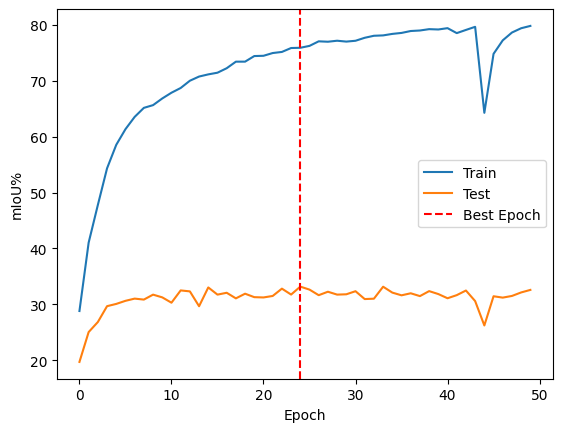

In [7]:
#Testing Domain Adaptation with Adversarial Training

#Set up the segmentation network (our Generator) with the pretrained weights
g_model = BiSeNet(num_classes=19, context_path='resnet18').to(device)

#Set up the loss function and the optimizer for the Generator
g_criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
g_optimizer = torch.optim.SGD(g_model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

#Set up the Discriminator
d_model = FCDiscriminator(num_classes=19).to(device)

#Set up the loss function and the optimizer for the Discriminator
d_criterion = torch.nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(d_model.parameters(), lr=1e-4, betas=(0.9, 0.99))

#Train the adversarial model
all_train_miou, all_test_miou, best_epoch = train_adversarial(g_model, d_model, g_criterion, d_criterion,
                                                              g_optimizer, d_optimizer,
                                                              source_flag, target_flag,
                                                              gta5_train_dataloader_aug1, cityscapes_test_dataloader,
                                                              interp_s, interp_t,
                                                              class_names, device, n_epochs, 'BiSeNet_adversarial')

plot_miou_over_epochs(all_train_miou, all_test_miou, best_epoch, 'BiSeNet_adversarial')